In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import torch
from torch import nn, optim
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image

from gan import models, build_gan_trainer, kl_gan_loss_step

from utils.checkpoints import load_checkpoint, save_checkpoint
from utils.display import display_images
from utils.benchmark import train
from __datasets__ import CelebADataset

In [12]:
config = models.DCGanConfig(
    "noise2celeb",
    writer=True,
    n=0,
    p=0,
    sampling_layers=5,
    lr=2e-4,
    blocks=(64, 128, 256, 512, 1024),
)

In [13]:
ds = CelebADataset(
    DIR="../../pytorch/datasets/celeb-a",
    download=True,
    sub_sample=0.1,
    image_transform=T.Compose([
        T.Resize((64, 64)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.to(config.device),
    ]),
)
len(ds)

20259

In [14]:
generator, discriminator = models.build_DCGan(config)
optimizerG = optim.Adam([*generator.parameters()], betas=config.betas)
optimizerD = optim.Adam([*discriminator.parameters()], betas=config.betas)

In [15]:
if input("Load Model[y|n]?> ").lower() == "y":
    others = load_checkpoint(
        input("path?> "),
        models={
            "generator": generator,
            "discriminator": discriminator,
        },
        optimizers={
            "generator": optimizerG,
            "discriminator": optimizerD,
        }
    )
    step_offset = others["step"]
else:
    step_offset = 0
print("step_offset:", step_offset)

step_offset: 0


In [16]:
def data_extractor(DATA):
    return DATA["image"], generator.sample_noise(len(DATA["image"]), device=config.device)


fixed_inp = data_extractor(ds[:9])[-1]
trainer = build_gan_trainer(
    generator, discriminator,
    optimizerG, optimizerD,
    kl_gan_loss_step,
    data_extractor,
    writer=config.writer, writer_period=500, fixed_inp=fixed_inp,
    save_path=config.checkpoint_path, save_period=1000,
    perceptual_loss=True,
    device=config.device
)

In [17]:
generator = generator.train()
discriminator = discriminator.train()
step_offset = train(
    trainer, ds,
    ne=2, bs=32,
    step_offset=step_offset,
)
step_offset

Epoch: 0/2 | Batch 0/634|          |  0% [00:00<?, ?it/s ]

KeyboardInterrupt: 

In [ ]:
if input("Save Model[y|n]?> ").lower() == "y":
    save_checkpoint(
        f"{config.name}-model.pth",
        models={
        },
    )

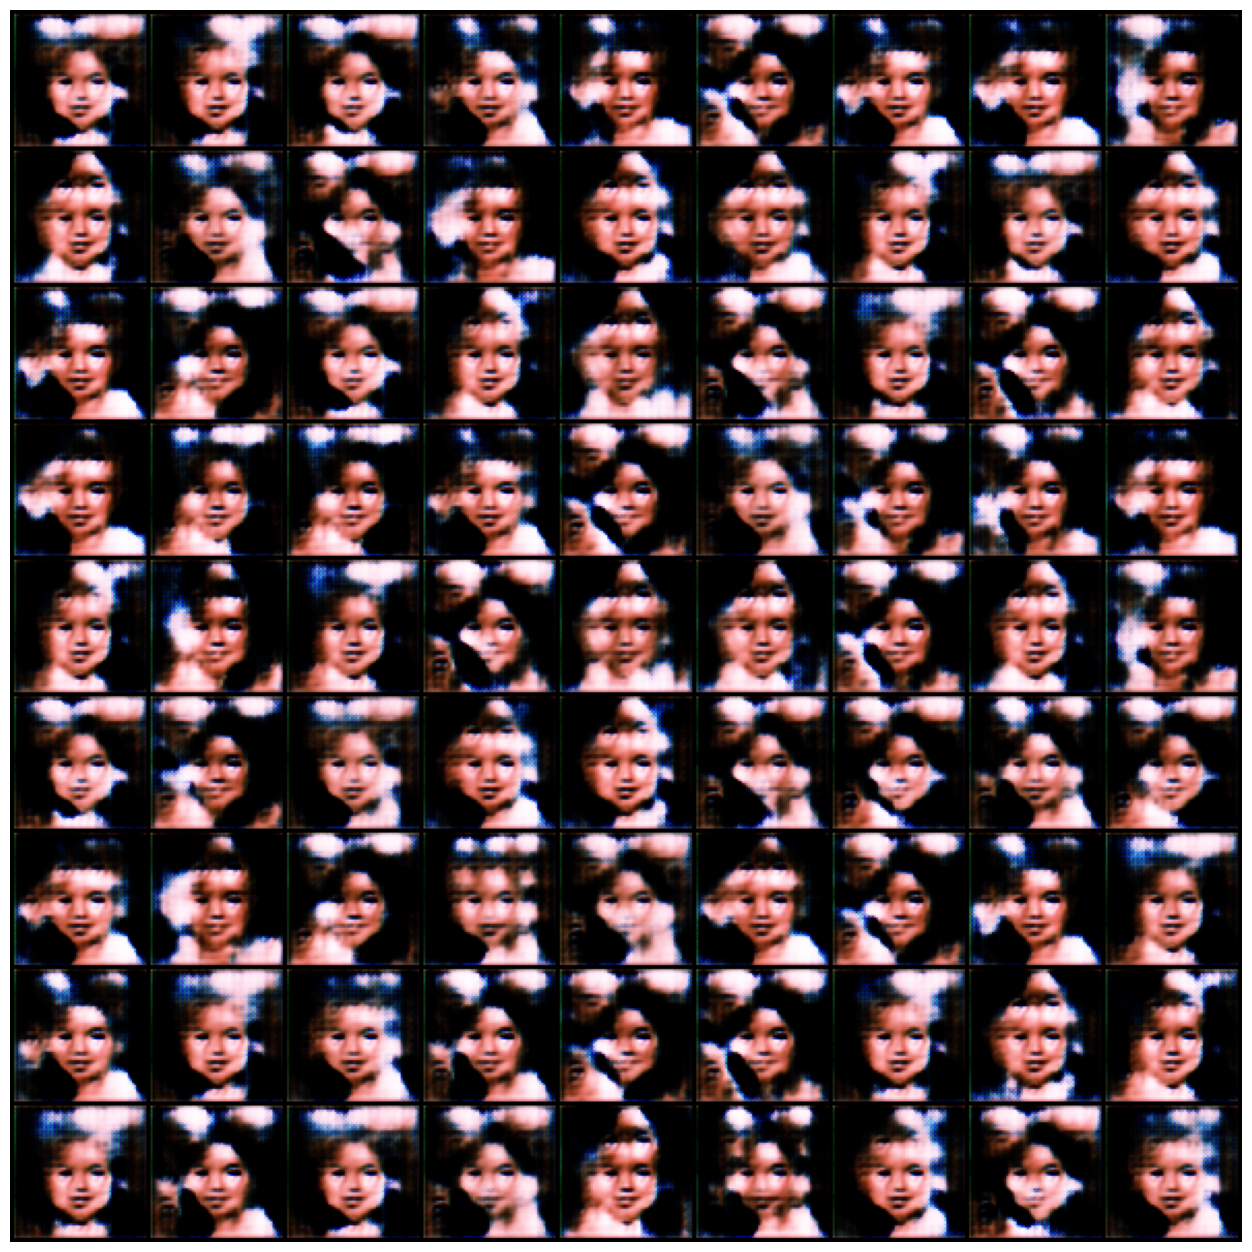

CPU times: user 1.22 s, sys: 295 ms, total: 1.51 s
Wall time: 2.79 s


In [19]:
%%time

generator = generator.eval()
discriminator = discriminator.eval()
with torch.inference_mode():
    fake = generator(generator.sample_noise(9 * 9, device=config.device))
    grid = make_grid(fake, nrow=9, normalize=True)
display_images(torch.stack([grid]).cpu().permute(0, 2, 3, 1))

In [ ]:
save_image(grid, "grid_fake.png")